In [1]:
import os
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import utils
from modules import RotationLSH, IdentityLSH, PcaLSH, RandomForestClustRegressor, PictureResolver

## cannot pickle properly with these enabled
# %load_ext autoreload
# %autoreload 2

## Generate training set

In [14]:
data_dir = '../data/Set14'
files = ['barbara.png', 'bridge.png', 'comic.png', 'pepper.png', 'man.png']

def generate_trainset(n_samples=50000, s=1/2, seed=7):
    # patch_size is (9,9)
    
    np.random.seed(seed)
    X = []
    Y = []
    for file in files:
        path = os.path.join(data_dir, file)
        img_h = utils.load_image(path)
        shape = img_h.shape
        new_shape = tuple(dim - (dim % int(1/s)) for dim in shape) # so that the HR and LR images have same size
        img_h = img_h[0:new_shape[0], 0:new_shape[1]]
        img_l = utils.resize(utils.resize(img_h, s), 1/s) # downsample -> upsample

        features = utils.get_features(img_l)
        img_out_delta = img_h - img_l
        assert img_h.shape == img_l.shape == img_out_delta.shape == new_shape

        x_ind = np.random.randint(0, new_shape[0]-9, size=n_samples//len(files))
        y_ind = np.random.randint(0, new_shape[1]-9, size=n_samples//len(files))
        for x, y in zip(x_ind, y_ind):
            feat_patch = features[x:x+9, y:y+9]
            delta_patch = img_out_delta[x:x+9, y:y+9]
            X.append(feat_patch.flatten())
            Y.append(delta_patch.flatten())

    X = np.array(X)
    Y = np.array(Y)
    return X, Y

## Train model

In [33]:
X, Y = generate_trainset(
    n_samples=50000,
    s=1/2,
    seed=7
)

# for testing
# X = np.random.randn(5000, 486)
# Y = np.random.randn(5000, 81)

print(X.shape)
print(Y.shape)

(50000, 486)
(50000, 81)


In [49]:
%%time

lsh = RotationLSH()
# lsh = IdentityLSH()
# lsh = PcaLSH(n_components=50)

lsh.fit(X)
X_comp = lsh.transform(X, binary=True)

rf = RandomForestClustRegressor(
    n_estimators=10,
    max_depth=15,
    n_jobs=None,
    max_features=10,
    min_samples_leaf=128,
    reg_type='ridge',
    alpha=1
)
rf.fit(X, X_comp, Y)

Wall time: 1min 25s
Parser   : 149 ms


In [ ]:
# save the model somewhere
model = {
    'lsh': lsh,
    'rf': rf
}
save_name = '../mymodel6.pkl'
with open(save_name, 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

    
## To load the model, do:
# with open(load_path, 'rb') as output:
#     model = pickle.load(output)
# lsh = model['lsh']
# rf = model['rf']

## Evaluate

C:\Users\jurg96\Desktop\Skoltech\Machine Learning\Project\FARF\modules\PictureResolver.py:34: RuntimeWarning: invalid value encountered in true_divide
  img_out_delta /= div_coef


Text(0.5, 0, 'Difference')

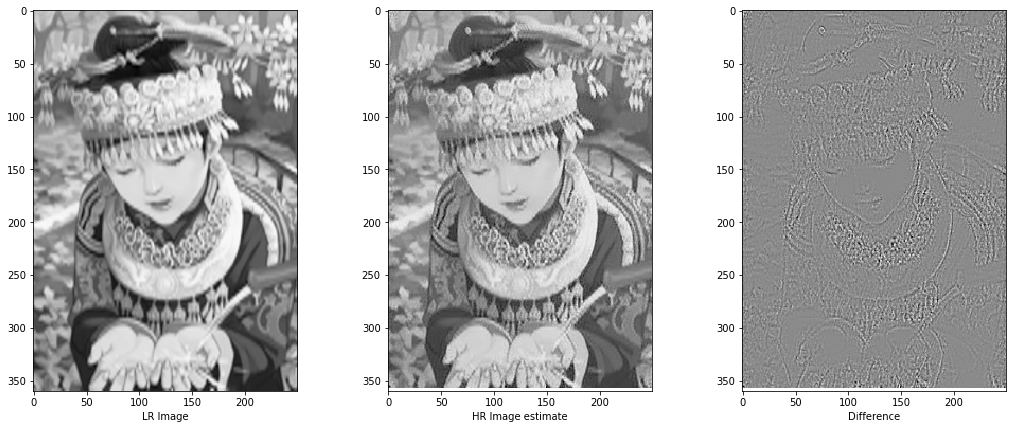

In [36]:
path_test = os.path.join(data_dir, 'comic.png')
img_test = utils.load_image(path_test)

s = 1/2
x = utils.resize(utils.resize(img_test, s), 1/s)

pr = PictureResolver(rf, lsh)
y = pr.resolve(x)

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(x, cmap='Greys_r')
ax[1].imshow(y, cmap='Greys_r')
ax[2].imshow(y-x, cmap='Greys_r')

ax[0].set_xlabel('LR Image')
ax[1].set_xlabel('HR Image estimate')
ax[2].set_xlabel('Difference')

Text(0.5, 0, 'Difference')

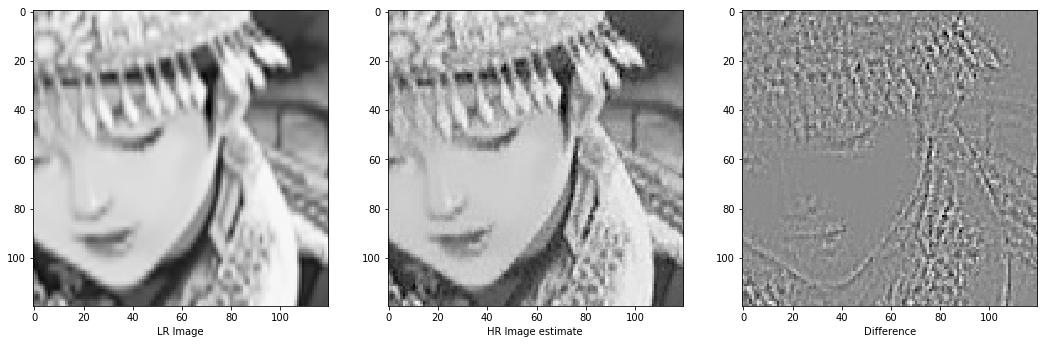

In [32]:
x_slice = slice(90,210)
y_slice = slice(90,210)

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(x[x_slice,y_slice], cmap='Greys_r')
ax[1].imshow(y[x_slice,y_slice], cmap='Greys_r')
ax[2].imshow((y-x)[x_slice,y_slice], cmap='Greys_r')

ax[0].set_xlabel('LR Image')
ax[1].set_xlabel('HR Image estimate')
ax[2].set_xlabel('Difference')